Copyright 2020 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Clone repo and import dependencies

In [6]:

import time
import numpy as np
import tensorflow.compat.v1 as tf
# tf.logging.set_verbosity(tf.logging.ERROR)  # Hide TF deprecation messages
import matplotlib.pyplot as plt

import modules
import data_utils

In [7]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

## Download pre-trained model weights from Google Cloud Storage

## Pre-trained model config

In [8]:
vertex_module_config=dict(
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=24,
      dropout_rate=0.4,
      re_zero=True,
      memory_efficient=True
      ),
  quantization_bits=8,
  class_conditional=True,
  max_num_input_verts=5000,
  use_discrete_embeddings=True,
  )

face_module_config=dict(
  encoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=10,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  decoder_config=dict(
      hidden_size=512,
      fc_size=2048,
      num_heads=8,
      layer_norm=True,
      num_layers=14,
      dropout_rate=0.2,
      re_zero=True,
      memory_efficient=True,
      ),
  class_conditional=False,
  decoder_cross_attention=True,
  use_discrete_vertex_embeddings=True,
  max_seq_length=8000,
  )

## Generate class-conditional samples

Try varying the `class_id` parameter to generate meshes from different object categories. Good classes to try are tables (49), lamps (30), and cabinets (32). 

We can also specify the maximum number of vertices / face indices we want to see in the generated meshes using `max_num_vertices` and `max_num_face_indices`. The code will keep generating batches of samples until there are at least `num_samples_min` complete samples with the required number of vertices / faces.

`top_p_vertex_model` and `top_p_face_model` control how varied the outputs are, with `1.` being the most varied, and `0.` the least varied. `0.9` is a good value for both the vertex and face models.

Sampling should take around 2-5 minutes with a colab GPU using the default settings depending on the object class.

In [9]:
tf.test.is_gpu_available()

True

Generating samples...
INFO:tensorflow:Restoring parameters from D:\PyCharmProjects\vertex_model\model
INFO:tensorflow:Restoring parameters from D:\PyCharmProjects\face_model\model
No vertex samples completed in this batch. Try increasing max_num_vertices.
No vertex samples completed in this batch. Try increasing max_num_vertices.
Num. samples complete: 1
sampling time: 238.0167555809021


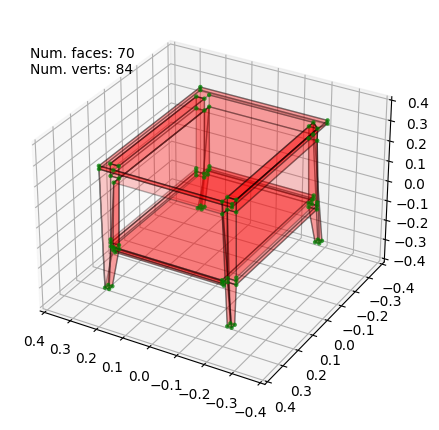

In [11]:
class_id = '49) table' #@param ['0) airplane,aeroplane,plane','1) ashcan,trash can,garbage can,wastebin,ash bin,ash-bin,ashbin,dustbin,trash barrel,trash bin','2) bag,traveling bag,travelling bag,grip,suitcase','3) basket,handbasket','4) bathtub,bathing tub,bath,tub','5) bed','6) bench','7) birdhouse','8) bookshelf','9) bottle','10) bowl','11) bus,autobus,coach,charabanc,double-decker,jitney,motorbus,motorcoach,omnibus,passenger vehi','12) cabinet','13) camera,photographic camera','14) can,tin,tin can','15) cap','16) car,auto,automobile,machine,motorcar','17) cellular telephone,cellular phone,cellphone,cell,mobile phone','18) chair','19) clock','20) computer keyboard,keypad','21) dishwasher,dish washer,dishwashing machine','22) display,video display','23) earphone,earpiece,headphone,phone','24) faucet,spigot','25) file,file cabinet,filing cabinet','26) guitar','27) helmet','28) jar','29) knife','30) lamp','31) laptop,laptop computer','32) loudspeaker,speaker,speaker unit,loudspeaker system,speaker system','33) mailbox,letter box','34) microphone,mike','35) microwave,microwave oven','36) motorcycle,bike','37) mug','38) piano,pianoforte,forte-piano','39) pillow','40) pistol,handgun,side arm,shooting iron','41) pot,flowerpot','42) printer,printing machine','43) remote control,remote','44) rifle','45) rocket,projectile','46) skateboard','47) sofa,couch,lounge','48) stove','49) table','50) telephone,phone,telephone set','51) tower','52) train,railroad train','53) vessel,watercraft','54) washer,automatic washer,washing machine']
num_samples_min = 1 #@param
num_samples_batch = 1 #8 #@param
max_num_vertices = 400 #@param
max_num_face_indices = 2000 #watch -n0.1 nvidia-smi@param
top_p_vertex_model = 0.9 #@param
top_p_face_model = 0.9 #@param

tf.reset_default_graph()

# Build models
vertex_model = modules.VertexModel(**vertex_module_config)
face_model = modules.FaceModel(**face_module_config)

# Tile out class label to every element in batch
class_id = int(class_id.split(')')[0])
vertex_model_context = {'class_label': tf.fill([num_samples_batch,], class_id)}
vertex_samples = vertex_model.sample(
    num_samples_batch, context=vertex_model_context,
    max_sample_length=max_num_vertices, top_p=top_p_vertex_model,
    recenter_verts=True, only_return_complete=True)
vertex_model_saver = tf.train.Saver(var_list=vertex_model.variables)

# The face model generates samples conditioned on a context, which here is
# the vertex model samples
face_samples = face_model.sample(
    vertex_samples, max_sample_length=max_num_face_indices,
    top_p=top_p_face_model, only_return_complete=True)
face_model_saver = tf.train.Saver(var_list=face_model.variables)

# Start sampling
start = time.time()
print('Generating samples...')
with tf.Session() as sess:
  vertex_model_saver.restore(sess, "D:\\PyCharmProjects\\vertex_model\\model")
  face_model_saver.restore(sess, 'D:\\PyCharmProjects\\face_model\\model')
  mesh_list = []
  num_samples_complete = 0
  while num_samples_complete < num_samples_min:
    v_samples_np = sess.run(vertex_samples)
    if v_samples_np['completed'].size == 0:
      print('No vertex samples completed in this batch. Try increasing ' +
            'max_num_vertices.')
      continue
    f_samples_np = sess.run(
        face_samples,
        {vertex_samples[k]: v_samples_np[k] for k in vertex_samples.keys()})
    v_samples_np = f_samples_np['context']
    num_samples_complete_batch = f_samples_np['completed'].sum()
    num_samples_complete += num_samples_complete_batch
    print('Num. samples complete: {}'.format(num_samples_complete))
    for k in range(num_samples_complete_batch):
      verts = v_samples_np['vertices'][k][:v_samples_np['num_vertices'][k]]
      faces = data_utils.unflatten_faces(
          f_samples_np['faces'][k][:f_samples_np['num_face_indices'][k]])
      mesh_list.append({'vertices': verts, 'faces': faces})
end = time.time()
print('sampling time: {}'.format(end - start))

data_utils.plot_meshes(mesh_list, ax_lims=0.4)

## Export meshes as `.obj` files
Pick a `mesh_id` (starting at 0) corresponding to the samples generated above. Refresh the colab file browser to find an `.obj` file with the mesh data.

In [ ]:
mesh_id = 1  #@param
data_utils.write_obj(
    mesh_list[mesh_id]['vertices'], mesh_list[mesh_id]['faces'], 
    'mesh-{}.obj'.format(mesh_id))